# 1. Find Co-Expressed Genes

## 1.1. Load required libraries and Initialize parameters

In [13]:
# Uncomment these lines in order to update the Cytoscape.js extension
# ====================================================================
import notebook.nbextensions
notebook.nbextensions.install_nbextension('https://cdnjs.cloudflare.com/ajax/libs/cytoscape/2.7.14/cytoscape.js', user=True)
# ====================================================================

'/Users/florian/Library/Jupyter/nbextensions/cytoscape.js'

In [2]:
re

<IPython.core.display.Javascript object>

## 1.2. Upload Gene Expression Results File

Upload Gen Expression results file - It doesn't matter what platform was used to generate the expression set ( RNASeq, Microarray, Methylation, ...) the assumption is the file contains multiple numeric measurements for a set of genes and a set of experiments.  The first column should contain the Gene Symbol. 

<img src="images/expression_set_info.png">

><span style="color:red">**Note: When loading files using R if header = TRUE and the first line of the file contains one entry less than the number of columns R assumes that the first column is the row name.  **</span>



In [14]:
%reload_ext rpy2.ipython

from ipywidgets import widgets
from IPython.display import HTML, display

# Basic CyRest Setup
PORT_NUMBER = 1234
BASE = 'http://localhost:' + str(PORT_NUMBER) + '/v1/'
# Header for posting data to Cytoscape as JSON
HEADERS = {'Content-Type': 'application/json'}

# Fixing the width and alignment of some widgets
display(HTML(
        '''<style>
               .widget-label { min-width: 26ex !important; }
               .form-control { min-width: 60ex !important; }
               .ui-slider { min-width: 20ex !important; }
           </style>'''
))
file_txt = widgets.Text(
    placeholder = 'Enter File Path...',
    value = '~/Downloads/SupplementaryDataTable1.txt',
    description = 'Gene Expression File:',
    disabled = False
)
display(file_txt)

In [16]:
exp_filepath = file_txt.value

# Upload file
%Rpush exp_filepath
%R expTable <- read.table(exp_filepath, header = TRUE, sep = "\t", quote="\"", stringsAsFactors = FALSE)
# Raw data (with gene in row and sample in colum)
%R data <- as.matrix(expTable)
%R cat("Upload Complete:", nrow(data), "genes")
display()

Upload Complete: 12042 genes

## 1.3. Calculate Co-Expression Measure
One metric that can be used to examine the supplied expression data is co-expression analysis.  Using one of many correlation measures including pearson, or spearman we can calculate how much the expression of each gene is similar to the other genes in the set.  For example, if your gene expression data consists of expression value from a diverse set of tissues or cell types computing correlation will highlight genes that are expressed in the same tissues. 
We start from the matrix of genes each with a set of expression values.  After calculating the correlation of this matrix we transform the data to a 2 dimentional matrix of gene to gene correlations where eash cell represents how correlated the two genes are (correlation is represented as a value betweeen -1 and 1 where -1 indicates anti-correlation and 1 indicates perfect correlation). 

<img src="images/correlation_creation_info.png">

In [17]:
coexp_measure = 'pearson'
%Rpush coexp_measure

# Create Form
def coexp_measure_rd_change(x):
    coexp_measure = x.new
    %Rpush coexp_measure

coexp_measure_rd = widgets.RadioButtons(
    description = 'Co-Expression Measure:',
    options = { 'Pearson\'s Correlation': 'pearson', 'Spearman\'s rank correlation': 'spearman' },
    value = coexp_measure
)
coexp_measure_rd.observe(coexp_measure_rd_change, names='value')
display(coexp_measure_rd)

### Translate correlation Matrix into a heatmap
To better visualize the gene correlations the correlation matrix can be shown as a heatmap.  Yellow squares along diagonal represent genes that have similar expression patterns

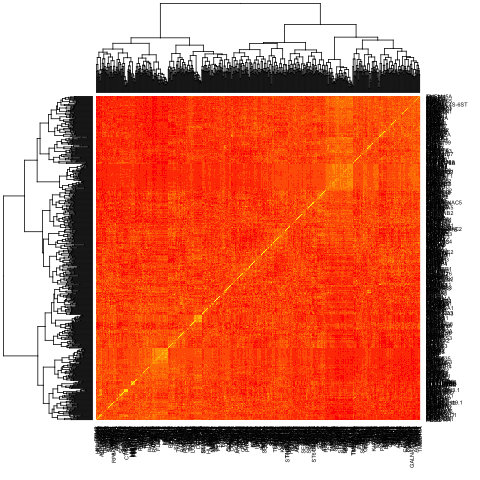

In [18]:
%%R
stand_dev <- apply(data, 1, sd)
### Correlation
corM = cor(t(data[which(stand_dev > 1.0),]), method = coexp_measure)
heatmap(corM)

## 1.4. Filter Genes and Translate Into Interaction Network
A Gene correlation network is an undirected graph where the nodes are genes and connections between them indicates their correaltion.  Filtering the correlation by a high threshold (for example cor > 0.95) will generate a network of genes that have highly similar expression in the experiments in question.

<img src="images/correlation_network_creation.png">

In [19]:
cutoff = 0.95
%Rpush cutoff

def on_cutoff_slider_change(x):
    cutoff = x.new
    %Rpush cutoff

cutoff_slider = widgets.FloatSlider(
    value = cutoff,
    min = 0.0,
    max = 1.00,
    step = 0.01,
    description='Exp. Correlation Cutoff:',
    disabled = False,
    continuous_update = False,
    orientation = 'horizontal',
    readout = True,
    readout_format = '.2f',
    slider_color = 'white'
)
cutoff_slider.observe(on_cutoff_slider_change, names='value')
display(cutoff_slider)

In [20]:
%%R
### Filter
interactions <- c()
for(i in 1:dim(corM)[1]){
    for(j in 1:dim(corM)[2]){
        if(i != j && corM[i,j] >= cutoff){
            interactions <- rbind(interactions, c(rownames(corM)[i], colnames(corM)[j], corM[i,j]))
        }
    }
}
cat('Co-Expression Interactions:\n\n')
print(interactions)

filteredGenes <- unique(interactions[,1])
cat("\nFiltered Genes (", length(filteredGenes), "):\n\n")
print(filteredGenes)

Co-Expression Interactions:

      [,1]     [,2]     [,3]               
 [1,] "COL1A1" "COL1A2" "0.951203344403157"
 [2,] "COL1A1" "COL5A1" "0.967375670783191"
 [3,] "HBB"    "HBA2"   "0.968164016618225"
 [4,] "COL3A1" "COL5A2" "0.952318233584267"
 [5,] "HBA2"   "HBB"    "0.968164016618225"
 [6,] "COL1A2" "COL1A1" "0.951203344403157"
 [7,] "COL5A1" "COL1A1" "0.967375670783191"
 [8,] "COL5A1" "COL5A2" "0.95199806063287" 
 [9,] "COL5A2" "COL3A1" "0.952318233584267"
[10,] "COL5A2" "COL5A1" "0.95199806063287" 

Filtered Genes ( 7 ):

[1] "COL1A1" "HBB"    "COL3A1" "HBA2"   "COL1A2" "COL5A1" "COL5A2"


# 2. Find More Genes

In [12]:
import requests
import json
import urllib.parse
import urllib.request
import operator
from ipywidgets import widgets
from IPython.display import HTML, display

organisms_url = 'http://genemania.org/json/organisms'
search_url = 'http://genemania.org/json/search_results'

%Rpull filteredGenes

# Fetch list of GeneMANIA organisms
organisms_resp = requests.get(organisms_url)
organisms_json = organisms_resp.json()
organisms_options = {}
organism_taxon_ids = {}

for item in organisms_json:
    organisms_options[item['alias']] = item['id']
    organism_taxon_ids[item['id']] = item['taxonomyId'] # So we can create the GeneMANIA linkout later

sorted_organisms = sorted(organisms_options.items(), key = operator.itemgetter(0))
    
# Create Form
organism_dd = widgets.Dropdown(
    description = 'Organism:',
    options = sorted_organisms,
)
genes_ta = widgets.Textarea(
    description = 'Genes:',
    value = "\n".join(filteredGenes),
)
cy_box = widgets.Box(
    id="cy"
)

display(organism_dd)
display(genes_ta)

LookupError: 'filteredGenes' not found

In [11]:
# Send search data to GeneMANIA
org_id = organism_dd.value
org_alias = list(organisms_options.keys())[list(organisms_options.values()).index(org_id)]
genes = genes_ta.value
req_json = {'organism': org_id, 'genes': genes}
headers = {'Content-Type': 'application/json'}

rreq_jsones = requests.post(search_url, json=req_json, headers=headers)

if res.status_code != 200:
    display(
        widgets.HTML(
            value = "<p style='color:#BA2121;'>Error from GeneMANIA: " + res.reason + "</p>"
        )
    )
else:
    res_json = res.json()
    cy_elements = []
    nodes = [] # For Cytoscape
    edges = [] # For Cytoscape

    for gene in res_json['resultGenes']:
        node = {
            'group': 'nodes',
            'data': {
                'id'         : str(gene['gene']['id']),
                'name'       : gene['gene']['symbol'],
                'shared_name': gene['gene']['symbol'],
                'queryGene'  : gene['queryGene'],
                'score'      : gene['score'],
            }
        }
        cy_elements.append(node)
        nodes.append(node)
    count = 10000000
    for net_gr in res_json['resultNetworkGroups']:
        gr_name = net_gr['networkGroup']['name']
        for net in net_gr['resultNetworks']:
            for inter in net['resultInteractions']:
                edge = {
                    'group': 'edges',
                    'data': {
                        'name'       : gr_name,
                        'shared_name': gr_name,
                        'source'     : str(inter['fromGene']['gene']['id']),
                        'target'     : str(inter['toGene']['gene']['id']),
                        'weight'     : inter['interaction']['weight'],
                    }
                }
                count = count + 1
                cy_elements.append(edge)
                edges.append(edge)

    els_json = json.dumps(cy_elements, default=lambda cy_elements: cy_elements.__dict__)

    cy_div = widgets.HTML(
        value="""<div id='cy' style="width: 100%; height: 500px; background: #f0f0f0;"></div>"""
    )
    js_script = widgets.HTML(
        value="""
            <script>
                $('#cy').show();
                var cy = cytoscape({
                    container: document.getElementById('cy'),
                    layout: { name: 'concentric' },
                    elements: %s,
                    style: [
                     {
                        selector: 'node',
                        style: {
                          'width': 'mapData(normScore, 0, 1, 20, 60)',
                          'height': 'mapData(normScore, 0, 1, 20, 60)',
                          'content': 'data(name)',
                          'font-size': 12,
                          'text-valign': 'center',
                          'text-halign': 'center',
                          'background-color': '#555',
                          'text-outline-color': '#555',
                          'text-outline-width': 1.75,
                          'color': '#fff',
                          'overlay-padding': 6,
                          'z-index': 10
                        }
                      },
                      {
                        selector: 'edge',
                        css: {
                          'opacity': 0.4,
                          'line-color': '#bbb',
                          'width': 'mapData(absoluteWeightPercent, 0, 1, 1.5, 16)',
                          'overlay-padding': 3
                        }
                      },
                    ]
                });
            </script>""" % els_json
    )
    
    display(cy_div)
    display(js_script)
    
    genemania_link_url = 'http://genemania.org/#/search/{}/{}'.format(
        organism_taxon_ids[organism_dd.value],
        "|".join(filteredGenes)
    )
    display(
        widgets.HTML(
            value = '<a href="{}" target="_blank">See network at genemania.org...</a>'.format(genemania_link_url)
        )
    )
    
    def on_create_cynet_btn_clicked(btn):
        # Export network to Cytoscape 3
        network = {
            'data'    : { 'name': org_alias },
            "elements": { "nodes": nodes, 'edges': edges }
        }
        res = requests.post(
            BASE + 'networks?collection=GeneMANIA Networks',
            data=json.dumps(network),
            headers=HEADERS
        )
        new_net_id = res.json()['networkSUID']
        print('Network created: SUID = ' + str(new_net_id))
        requests.get(BASE + 'apply/layouts/force-directed/' + str(new_net_id))
    
    create_cynet_btn = widgets.Button(
        description = 'Open in Cytoscape...',
    )
    create_cynet_btn.on_click(on_create_cynet_btn_clicked)
    display(create_cynet_btn)

NameError: name 'organism_dd' is not defined